In [1]:
import findspark
findspark.init('/home/sdmohant/spark-3.0.0-bin-hadoop2.7')

In [2]:
import pyspark
from pyspark import SparkContext,SparkConf

In [3]:
from pyspark.sql import SparkSession

In [4]:
#spark = SparkSession.builder.appName("MyApp").getOrCreate()
#spark = SparkSession.builder.appName("MyName").getOrCreate()
conf = SparkConf().set("spark.cores.max", "16") \
    .set("spark.driver.memory", "16g") \
    .set("spark.executor.memory", "16g") \
    .set("spark.executor.memory_overhead", "16g") \
    .set("spark.driver.maxResultsSize", "0") \
    .set("spark.sql.shuffle.partitions","300")

sc = SparkContext(appName="physicsmodel", conf=conf)
spark = SparkSession(sc)

/home/sdmohant/spark-3.0.0-bin-hadoop2.7/python/pyspark/context.py:220: DeprecationWarning: Support for Python 2 and Python 3 prior to version 3.6 is deprecated as of Spark 3.0. See also the plan for dropping Python 2 support at https://spark.apache.org/news/plan-for-dropping-python-2-support.html.
  DeprecationWarning)


In [5]:
from pyspark.sql.functions import isnan, count, col, when

In [6]:
physicsFODID = spark.read.options(header = True, inferSchema = True,delimiter=',').csv("FOSDomains.csv")

In [7]:
physicsFODID = physicsFODID.filter(physicsFODID["Domain"]=="Physics").collect()

In [8]:
len(physicsFODID)

271

In [9]:
papers = spark.read.options(header = True, inferSchema = True,delimiter=',').csv("AllPapersFOS1.csv")

In [10]:
from pyspark.sql.types import ArrayType, StructField, StructType, StringType, IntegerType,LongType

In [11]:
schema = StructType([
    StructField('FOS_ID', LongType(), True),
    StructField('Domain', StringType(), True)
])

In [12]:
# Convert list to RDD
rdd = spark.sparkContext.parallelize(physicsFODID)

# Create data frame
fos = spark.createDataFrame(rdd,schema)

In [13]:
fos.show(2)

+--------+-------+
|  FOS_ID| Domain|
+--------+-------+
|24890656|Physics|
|97355855|Physics|
+--------+-------+
only showing top 2 rows



In [14]:
papers_filtered = papers.join(fos,on="FOS_ID",how="inner")

In [15]:
papers_filtered.count()

5117595

In [16]:
papers_filtered = papers_filtered.withColumnRenamed("CitationCount","label")

In [17]:
papers_filtered.columns

['FOS_ID',
 'PaperID',
 'Rank',
 'PaperYear',
 'Volume',
 'Issue',
 'ReferenceCount',
 'label',
 'EstimatedCount',
 'PaperAge',
 'IsJournal',
 'min_FOSRank',
 'max_FOSRank',
 'max_FOSPaperCount',
 'min_FOSPaperCount',
 'min_FOSCitationCount',
 'max_FOSCitationCount',
 'PaperRefCnt',
 'Domain']

In [18]:
drop_cols = ["FOS_ID","PaperID","EstimatedCount","Domain","PaperYear","Volume","Issue"]
papers_filtered = papers_filtered.drop(*drop_cols)

In [19]:
papers_filtered1 = papers_filtered.select(["Rank","ReferenceCount","PaperAge",\
                        "IsJournal","min_FOSRank","max_FOSRank","max_FOSPaperCount","min_FOSPaperCount","min_FOSCitationCount",\
                        "max_FOSCitationCount","PaperRefCnt","label"])

In [27]:
(sample1,sample2) = papers_filtered1.randomSplit([0.5,0.5])

In [28]:
from sklearn import model_selection
from sklearn.model_selection import KFold

In [29]:
from sklearn.ensemble import RandomForestRegressor

In [30]:
papers_pd = sample1.toPandas()

In [32]:
papers_pd.shape

(2559241, 12)

In [31]:
X = papers_pd.iloc[:, 0:11].values
y = papers_pd.iloc[:, 11].values

In [25]:
y[0:5]

array([18,  0, 13, 14,  0], dtype=int32)

In [37]:
#kfold = model_selection.KFold(n_splits=5, random_state=10)
#model = RandomForestRegressor(n_estimators= 1000,max_depth=3)

In [38]:

#results = model_selection.cross_val_score(model, X, y, cv=kfold,scoring="neg_mean_absolute_error")


In [39]:
#print("Neg Mean Abosulte error: %.3f%% " % (results.mean()))

In [40]:
import numpy as np
from sklearn.model_selection import StratifiedKFold

In [41]:
(sample11,sample12) = sample1.randomSplit([0.5,0.5])

In [42]:
df = sample11.toPandas()

In [43]:
df.shape

(1279121, 12)

In [46]:
X = df.iloc[:, 0:11].values
y = df.iloc[:, 11].values

## Stratified 5 Folds

In [47]:
skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(X, y)

5

## Random Regresssion using 

In [48]:
from sklearn import metrics
rmse_list = []
for train_index, test_index in skf.split(X,y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    regressor = RandomForestRegressor(n_estimators=1000, max_depth=3, random_state=0)
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    rmse_list.append(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    


/home/sdmohant/.virtualenvs/datascience/local/lib/python2.7/site-packages/sklearn/model_selection/_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


('TRAIN:', array([   8653,   11346,   25178, ..., 1279118, 1279119, 1279120]), 'TEST:', array([      0,       1,       2, ..., 1270681, 1274810, 1278025]))
('Mean Absolute Error:', 10.501574830170567)
('Mean Squared Error:', 5301.748469501873)
('Root Mean Squared Error:', 72.81310644040586)
('TRAIN:', array([      0,       1,       2, ..., 1279118, 1279119, 1279120]), 'TEST:', array([   8653,   11346,   25178, ..., 1250526, 1252185, 1266706]))
('Mean Absolute Error:', 8.432122614997114)
('Mean Squared Error:', 684.5046458099604)
('Root Mean Squared Error:', 26.163039689798286)
('TRAIN:', array([      0,       1,       2, ..., 1279118, 1279119, 1279120]), 'TEST:', array([  25513,   25833,   26683, ..., 1216221, 1251054, 1256642]))
('Mean Absolute Error:', 7.612294257801979)
('Mean Squared Error:', 444.5593508178578)
('Root Mean Squared Error:', 21.08457613559869)
('TRAIN:', array([      0,       1,       2, ..., 1279118, 1279119, 1279120]), 'TEST:', array([ 101092,  219083,  219162, ...

In [49]:
rmse_list

[72.81310644040586,
 26.163039689798286,
 21.08457613559869,
 20.094044923636353,
 19.212421826539135]

In [57]:
rmse_sum = 0
for index in range(0,5):
    rmse_sum = rmse_sum + rmse_list[index]
mean_rmse = rmse_sum/5
print("Mean RMSE is :",mean_rmse)

('Mean RMSE is :', 31.873437803195664)


In [64]:
import xgboost as xgb

In [65]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [67]:
regressor = xgb.XGBRegressor(
    n_estimators=100,
    reg_lambda=1,
    gamma=0,
    max_depth=3
)

In [68]:
regressor.fit(X_train, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)

In [69]:
y_pred = regressor.predict(X_test)

In [70]:
np.sqrt(metrics.mean_squared_error(y_test, y_pred))

24.45901250070523

In [71]:
skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(X, y)

5

In [72]:
rmse_list = []
for train_index, test_index in skf.split(X,y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    regressor = xgb.XGBRegressor(
                n_estimators=100,
                reg_lambda=1,
                gamma=0,
                max_depth=3
                )
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    rmse_list.append(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
    print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
    print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

('TRAIN:', array([   8653,   11346,   25178, ..., 1279118, 1279119, 1279120]), 'TEST:', array([      0,       1,       2, ..., 1270681, 1274810, 1278025]))
('Mean Absolute Error:', 6.304092534267572)
('Mean Squared Error:', 3687.4581402606877)
('Root Mean Squared Error:', 60.72444433883844)
('TRAIN:', array([      0,       1,       2, ..., 1279118, 1279119, 1279120]), 'TEST:', array([   8653,   11346,   25178, ..., 1250526, 1252185, 1266706]))
('Mean Absolute Error:', 4.870164329484004)
('Mean Squared Error:', 335.1757939864807)
('Root Mean Squared Error:', 18.307806913622414)
('TRAIN:', array([      0,       1,       2, ..., 1279118, 1279119, 1279120]), 'TEST:', array([  25513,   25833,   26683, ..., 1216221, 1251054, 1256642]))
('Mean Absolute Error:', 4.37072813199996)
('Mean Squared Error:', 201.92475527257238)
('Root Mean Squared Error:', 14.210023056722054)
('TRAIN:', array([      0,       1,       2, ..., 1279118, 1279119, 1279120]), 'TEST:', array([ 101092,  219083,  219162, ..

In [73]:
rmse_sum = 0
for index in range(0,5):
    rmse_sum = rmse_sum + rmse_list[index]
mean_rmse = rmse_sum/5
print("Mean RMSE is :",mean_rmse)

('Mean RMSE is :', 23.970438938396246)


In [74]:
from sklearn import metrics
rmse_list = []
for train_index, test_index in skf.split(X,y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    regressor = RandomForestRegressor(n_estimators=100, max_depth=3, random_state=0)
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    rmse_list.append(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print('Mean Absolute Error with less estimators:', metrics.mean_absolute_error(y_test, y_pred))
    print('Mean Squared Error with less estimators:', metrics.mean_squared_error(y_test, y_pred))
    print('Root Mean Squared Error with less estimators:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    

('TRAIN:', array([   8653,   11346,   25178, ..., 1279118, 1279119, 1279120]), 'TEST:', array([      0,       1,       2, ..., 1270681, 1274810, 1278025]))
('Mean Absolute Error with less estimators:', 10.505231426068026)
('Mean Squared Error with less estimators:', 5311.671203102948)
('Root Mean Squared Error with less estimators:', 72.88121296399332)
('TRAIN:', array([      0,       1,       2, ..., 1279118, 1279119, 1279120]), 'TEST:', array([   8653,   11346,   25178, ..., 1250526, 1252185, 1266706]))
('Mean Absolute Error with less estimators:', 8.452242815517955)
('Mean Squared Error with less estimators:', 688.6839756149031)
('Root Mean Squared Error with less estimators:', 26.242789021270266)
('TRAIN:', array([      0,       1,       2, ..., 1279118, 1279119, 1279120]), 'TEST:', array([  25513,   25833,   26683, ..., 1216221, 1251054, 1256642]))
('Mean Absolute Error with less estimators:', 7.628409145529364)
('Mean Squared Error with less estimators:', 445.253663556171)
('Root

In [75]:
rmse_sum = 0
for index in range(0,5):
    rmse_sum = rmse_sum + rmse_list[index]
mean_rmse = rmse_sum/5
print("Mean RMSE is :",mean_rmse)

('Mean RMSE is :', 31.89913089206189)


In [76]:
skf = StratifiedKFold(n_splits=5)
skf.get_n_splits(X, y)

5

In [77]:
from sklearn import metrics
rmse_list = []
for train_index, test_index in skf.split(X,y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    regressor = RandomForestRegressor(n_estimators=100, max_depth=30, random_state=0)
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    rmse_list.append(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    print('Mean Absolute Error with less estimators:', metrics.mean_absolute_error(y_test, y_pred))
    print('Mean Squared Error with less estimators:', metrics.mean_squared_error(y_test, y_pred))
    print('Root Mean Squared Error with less estimators:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))
    

('TRAIN:', array([   8653,   11346,   25178, ..., 1279118, 1279119, 1279120]), 'TEST:', array([      0,       1,       2, ..., 1270681, 1274810, 1278025]))
('Mean Absolute Error with less estimators:', 5.503004584652553)
('Mean Squared Error with less estimators:', 3430.3669366549266)
('Root Mean Squared Error with less estimators:', 58.56933443923472)
('TRAIN:', array([      0,       1,       2, ..., 1279118, 1279119, 1279120]), 'TEST:', array([   8653,   11346,   25178, ..., 1250526, 1252185, 1266706]))
('Mean Absolute Error with less estimators:', 3.769725325531085)
('Mean Squared Error with less estimators:', 346.76013096622546)
('Root Mean Squared Error with less estimators:', 18.621496474940606)
('TRAIN:', array([      0,       1,       2, ..., 1279118, 1279119, 1279120]), 'TEST:', array([  25513,   25833,   26683, ..., 1216221, 1251054, 1256642]))
('Mean Absolute Error with less estimators:', 3.366487688997392)
('Mean Squared Error with less estimators:', 179.76609137040944)
('R

In [78]:
rmse_sum = 0
for index in range(0,5):
    rmse_sum = rmse_sum + rmse_list[index]
mean_rmse = rmse_sum/5
print("Mean RMSE is :",mean_rmse)

('Mean RMSE is :', 22.98567998243858)


In [89]:
featureslist=df.columns

Text(0.5,1,'Feature Importances')

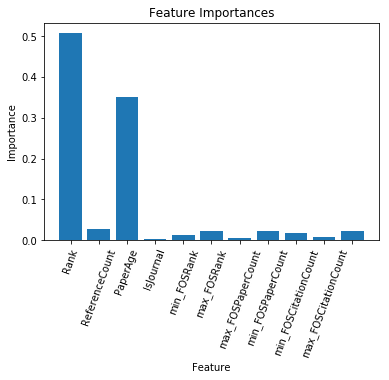

In [91]:
importances = regressor.feature_importances_

x_values = list(range(len(importances)))

plt.bar(x_values, importances, orientation = 'vertical')
plt.xticks(x_values, featureslist[0:10], rotation=70)
plt.ylabel('Importance')
plt.xlabel('Feature')
plt.title('Feature Importances')

In [93]:
for i,v in enumerate(importances):
	print('Feature: %0d, Score: %.5f' % (i,v))

Feature: 0, Score: 0.50733
Feature: 1, Score: 0.02662
Feature: 2, Score: 0.35080
Feature: 3, Score: 0.00335
Feature: 4, Score: 0.01201
Feature: 5, Score: 0.02326
Feature: 6, Score: 0.00602
Feature: 7, Score: 0.02220
Feature: 8, Score: 0.01884
Feature: 9, Score: 0.00705
Feature: 10, Score: 0.02252
